Hans Hwang and Jenniber Franco

## CS341 Project 4: Genetic Algorithms

Your first goal is to analyze the performance of several genetic algorithms in the context of parameter-estimation. Your second goal is to analyze the results, i.e. what do we learn about the model? In this project, we are revisiting Goldbeter's 5-state fly clock model, whose parameters were originally chosen "by hand." You will use a cost function which ensures the oscillations in constant darkness have a period of 23.6 hours.

There are many, many variants of genetic algorithms. We will be using the following algorithm.

<ul>
    <li>Create an initial population of $\lambda$ individuals $G^0$ and generate their costs.
    <li>Sort the individuals by cost (in preparation for selection)
    <li>For each generation $g$
        <ul>
        <li>Take the $eliteCount$ best children from the previous generation $G^{g-1}$ and put them into this generation $G^g$
        <li>Select the breeding pool $P$ of $\mu$ individuals from the previous generation.
        <li>For i in range($eliteCount$,$\lambda$)
            <ul>
            <li>Randomly select two parents from $P$.
            <li>Use cross-over to generate a child $G^g_i$.
            <li>Mutate the values in $G^g_i$.
            <li>Compute the child's cost.
            </ul>
        <li>Sort the individuals in $G^g_i$ by cost (in preparation for selection)
        </ul>
</ul>   

The key operators and parameters can be varied:
<ul>
    <li>Selection can favor fit (low-cost) parents more or less. If we favor them more, then the algorithm converges quickly, but it doesn't explore parameter space very well, and could miss a more fit individual. If we favor them less, the algorithm might not find children of increasingly good fitness. Explanations of several selection operators may be found in: Blickle, T. and Thiele, L. 1995. A comparison of selection schemes used in genetic algorithms. Tech. Rep. TIK-Report 11, Swiss Federal Institute of Technology (ETH), Zurich, Switzerland, May.
    <li>Crossover is typically "uniform" (each element of the child is randomly taken from one of its two parents) or "single" (a cross-over point is selected and all elements up to the cross-over point are taken from one parent and the remaining elements are taken from the second parent).
    <li>Mutation is typically implemented by choosing a value from a Gaussian distribution centered on each element. One straightforward way to vary the mutation is to vary the width of the distribution. We control the size of the mutation by scaling the width of the Gaussian distribution (it should be $mutationScale\cdot parameterValue$).
    <li>The number of parents $\mu$ and children $\lambda$ affects how widely we can sample space. Large numbers of children allow for a broader sampling. The number of parents (the size of the breeding pool) should be a fraction of the number of children (typically, it is a number like 1/5). It works with the selection operator to control how broadly the space is searched and how quickly the algorithm progresses towards a solution. The number of children that you need to use depends upon the problem. It can range from in the tens (e.g. our simple island cost function from class) to thousands.
    <li>The number of elite individuals should be small (e.g. 1 to 3). Including elites guarantees that the best-fit individual in generation $g$ will be at least as fit as the best-fit individual in generation $g-1$.
    <li>The number of generations should be as big as it needs to be for the best (or average) cost to stop improving. For some problems, thousands of generations are used. Here, we are able to use many fewer (e.g. I used 5 for the simple island cost function in class)
</ul>  

## Algorithm Performance

<ol>
<li> Run each algorithm on the fly model at least 5 times for each ``flavor'' for at least 5 generations,  i.e. analyze performance for 
	<ol>
    <li> a GA with truncation selection, an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
	<li> a GA with tournament selection (tournament size = 2), an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
	<li> a GA with linear ranking selection, an elite count of 1, 8 parents, 40 children, and a mutation fraction of 0.05
    </ol>
<li> Report your results in a concise, but informative manner. You will want to identify trends. To do this, quantify the performance of the algorithm. For example, determine the mean population cost from generation to generation.
</ol>

## Implication for Model
Using some of your output from above, analyze the effects of different parameters on the model's performance. Below are suggestions to guide your analysis. Follow at least one of them.

<ol>
<li> How different are the parameter sets? Do wildly different parameter sets map to wildly different outputs? Are their patterns?
<li> You may see different relationships between amplitudes of clock components. Do you see any patterns in this behavior? If not, maybe you can conclude that the relative amplitude is not a property of the model's parameters, but that it is a property of its structure. Make a detailed case for your conclusion.
<li> Choose several parameter sets and determine whether or not the non-intuitive behavior mentioned in Goldbeter's paper occurs. In his paper, he showed that increasing the rate of Per protein degradation ($v_d$) increases the total PER in the system. Is this true for multiple parameter sets?
</ol>

## Extensions

<ul>
<li> Implement proportional selection and include analysis of the GA with proportional selection it in your write-up.
<li> Include additional analysis with different values of the algorithm's parameters. What happens if the number of children per generation is different? What about increasing or decreasing the mutation fraction?
<li> Include simulated annealing in your set of optimization algorithms.
<li> Implement a simulated annealing optimization algorithm.
<li> Make a hybrid algorithm that uses both a GA (or simulated annealing) and a deterministic method (e.g. a hill-descending method). The idea is that the stochastic algorithms helps you find the right region of parameter space, and that in that region, the cost function will be smooth (and maybe even monotonic). Once we are in a region that is smooth and monotonic, we can use a deterministic optimization method to refine our parameter set to find the local optimum.
<li> Include amplitude in the cost function for Goldbeter's model: add a penalty for each state variable whose peak-to-trough amplitude is less than 0.1.
<li> Also find parameters for the Gonze/Goodwin oscillator.
</ul>


## Steps to get you started
### 1. Cost function for fly clock model

To write the cost function for the fly clock model, you will need gol95_model and get_period from project 2. 

Your cost function should have the signature:
<code>
def gol95_cost( params ):    
</code>

where params is the ndarray of parameters used to simulate the model.

It should
<ul>
    <li>Run the simulation with params as the parameters for at least 10 days, so that it is likely to have reached the limit cycle.
    <li>Re-run the simulation, beginning with the values from the final time step of the previous simulation.
    <li>Compute the period $per$ and the cycle-to-cycle standard deviation of the period $sdper$ by calling get_period.
    <li>Compute the cost according to
        $\sqrt{ \frac{per-23.6}{23.6}^2 + sdper/23.6}$
</ul>


In [3]:
## Write your code here (copy-paste the model and get_period, write gol95_cost)
import numpy as np
import scipy.integrate
import scipy.signal

def negative_feedback(t, statevars, params):
    M = statevars[0]
    P0 = statevars[1]
    P1 = statevars[2]
    P2 = statevars[3]
    PN = statevars[4]
    PT = statevars[5]

    vs = params[0]
    vm = params[1]
    Km = params[2]
    ks = params[3]
    vd = params[4]
    k1 = params[5]
    k2 = params[6]
    KI = params[7]
    Kd = params[8]
    n = params[9]
    K1 = params[10]
    K2 = params[11]
    K3 = params[12]
    K4 = params[13]
    V1 = params[14]
    V2 = params[15]
    V3 = params[16]
    V4 = params[17]

    dydt = np.zeros( (6,) )
    dydt[0] = ( vs * ((KI**n)/(KI**n + PN**n)) ) - ( vm * ((M)/(Km + M)) )
    dydt[1] = ks*M - (V1 * ((P0)/(K1+P0))) + (V2 * ((P1)/(K2+P1)))
    dydt[2] = (V1*((P0)/(K1+P0))) - (V2*((P1)/(K2+P1))) - (V3*((P1)/(K3+P1))) + (V4*((P2)/(K4+P2)))
    dydt[3] = (V3*((P1)/(K3+P1))) - (V4*((P2)/(K4+P2))) - (k1*P2) + (k2*PN) - (vd*((P2)/(Kd+P2)))
    dydt[4] = (k1*P2) - (k2*PN)
    dydt[5] = dydt[1]+dydt[2]+dydt[3]+dydt[4]
    return dydt

def get_period(arr,t):
    peaks, _ = scipy.signal.find_peaks(arr)
    #print(peaks)
    time = []
    for peak in peaks:
        time.append(t[peak])
    periods = []
    #print(time)
    for i in range(len(time)-1,0,-1):
        periods.append(time[i] - time[i-1])
        
    return (np.mean(periods), np.std(periods))
    #return np.mean(periods)

def gol95_cost(params):
    initial = (0.5, 0.5, 0.5, 0.5, 1, 2)
    initial = (1,1,1,1,1,1)
    nf = lambda t,y : negative_feedback(t, y, params)
    sol1 = scipy.integrate.solve_ivp(fun=nf, t_span=(0,240), y0=initial, t_eval=np.arange(0,240,0.01))
    sol2 = scipy.integrate.solve_ivp(fun=nf, t_span=(0,240), y0=sol1.y[:,-1], t_eval=np.arange(0,240,0.01), rtol=1e-8)
    (per, sdper) = get_period(sol2.y[0,:], sol2.t)
    #print(per, sdper)
    #per = get_period(sol2.y[1,:], sol2.t)
    #sdper = np.std(per)
    return np.sqrt( ((per-23.6)/23.6)**2 + sdper/23.6 )

vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5
params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)

print(gol95_cost(params))

# Test your cost function here.
# When Stephanie tests hers with the parameters from Project 2, her cost is
# 0.0027454617448506194

0.013531896019340541


### 2. Selection operator

Write your selection operators in this cell, so that you can test them with artificial data. I have included a barebones operator along with test code below. The uniform operator is a useless one, because it applies no selection pressure. The test code has costs ranging from 0.1 to 500 and the uniform operator samples from them all, so the histogram of costs from the breeding pool should indicate a uniform distribution from 0.1 to 500. 

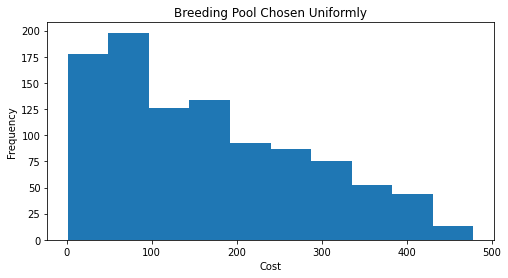

In [4]:
import matplotlib.pyplot as plt
import numpy as np

class GASettings:
    def __init__( self, numParents = 10, numChildren = 50 ):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation'; 
        self.slope = 15; # for linear ranking selection
        self.tournamentSize = 2;
        self.crossover = 'uniform';
        self.mutation = 0.05; # std of normal distribution computed as mutation*value
        self.eliteCount = 1;
        self.linearRankingRatio = 4;

def select_pool( G, Gcost, settings ):
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )
    Pidxs = []
    if settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == "tournament":
        for i in range(settings.numParents):
            idx = (np.random.choice(G.shape[0], (settings.tournamentSize,))).min() #we are looking through indexes here
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == "linearRanking":
        r = settings.linearRankingRatio
        n = settings.numChildren
        pn = 2/n*(1/(1+r))
        p1 = r*pn
        ps = np.zeros((n,))
        for i in range(1,n+1):
            ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
        cs = ps.cumsum()

        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == "proportional":
        n = settings.numChildren

        sumCost = np.sum(Gcost[:n])
        ps = np.zeros((n,))
        for i in range(len(ps)):
            ps[i] = Gcost[i]/sumCost
        cs = ps.cumsum()
        cs = 1 - cs
        cs.sort()
        for i in range(settings.numParents):
            num = np.random.random()
            idx = np.argmax(num<cs)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    else:
        print("Unknown selection operator: ", settings.selection)
    return (P, Pcost)

# Test the selection operators
# Make fake parameters, using the index as the values (so we can differentiate them)
lam = 10000 # number of individuals in generation
mu = 1000 # number of individuals in breeding pool
NP = 5 # num of parameters per individual
G = np.zeros( (lam,NP) )
for i in range(lam):
    G[i,:] = i
Gcost = np.linspace(0.1,500,lam)
settings = GASettings(numParents=mu, numChildren=lam)

settings.selection = 'proportional'
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen Uniformly")
plt.xlabel( 'Cost')
plt.ylabel('Frequency');



### 3. Test cross-over and mutation

Stephanie puts cross-over and mutation in a function named generateChild. The input to generateChild is the cost function, the breeding pool, the lower bounds, the upper bounds, and the settings. You can test it by generating an artificial breednig pool, such as one in which the first individual is an array of all 1's, the second is all 2's etc. Then, if you print out the results, which two individuals were chosen, how the cross-over was done and how the mutation worked should be clear.

In [5]:
# Write your code for testing cross-over and mutation here.
def generateChild(cost_fcn, P, lb, ub, settings):
    params = np.zeros(lb.shape)
    cost   = np.inf
    for i in range(1000):
        P1idx = np.random.choice(P.shape[0])#pick a parent
        P1  = P[P1idx,:]#chooses that parent
        P2idx = np.random.choice(P.shape[0])#picks another
        P2  = P[P2idx,:]#chooses and locks second
        for j in range(lb.size):
            if np.random.random() < 0.5:
                params[j] = P1[j]
            else:
                params[j] = P2[j]
        #50% to get one trait from one, and 50 for other
        # Mutate optimization variables
        params = np.multiply( 1+np.random.randn(params.size)*settings.mutation, params)#mutation
        # Make sure the mutation hasn't moved us out of bounds
        params = np.maximum(params,lb)#bigger of what it is and the lower bound
        params = np.minimum(params,ub)#smaller of what it is and upper bound
        cost   = cost_fcn(params) # same cost function area as before

        if np.isfinite(cost):
            return ( params, cost )
    return (np.zeros((lb.size)), np.inf)

lam = 50 # number of individuals in generation
mu = 2 # number of individuals in breeding pool
NP = 18 # num of parameters per individual 
P = np.zeros( (mu,NP) )
for i in range(mu):
    P[i,:] = i % 5 + 1
settings = GASettings(numParents=mu, numChildren=lam)

lb = np.zeros((18,))
ub = 5 + np.zeros((18,))
(params,cost) = generateChild( gol95_cost, P, lb, ub, settings )

print( "Breeding Pool")
print( P )
print( "Child")
print(params)

Breeding Pool
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
Child
[2.13709467 2.0159961  1.95856177 1.87663585 2.0408232  1.98884886
 2.19844134 1.80237286 1.94022457 2.03787721 1.98388661 1.79237908
 1.9823264  2.07315495 2.03012682 2.04990535 1.9926568  1.82754297]


### 4. Write your Genetic Algorithm

Write it according to the algorithm above and what we have done in class.

Test it with the simple island cost function from class.

Best of generation  1  has cost  2.4459254292325903
Generation  1  has a mean cost of  4.150567840416909
Best of generation  2  has cost  2.1395706067172897
Generation  2  has a mean cost of  3.241186979588589
Best of generation  3  has cost  1.3087165352882748
Generation  3  has a mean cost of  2.628469504815363
Best of generation  4  has cost  1.3087165352882748
Generation  4  has a mean cost of  2.1802254381007606
Best of generation  5  has cost  1.1159295622509895
Generation  5  has a mean cost of  1.6015039043641104


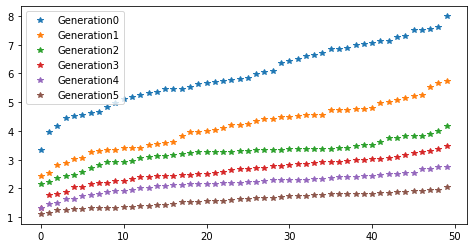

In [6]:
# Your GA code goes here! Copy-paste the simple island cost function from the Jupyter notebook from class.
def generateIndividual(cost_fcn, lb,ub):
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

def GA(cost_fcn, lb, ub, settings):
    mu = settings.numParents;
    lam = settings.numChildren;
    numGenerations = settings.numGenerations;

    # Create initial population
    G = np.zeros( (lam,lb.size) );
    Gcost = np.zeros( (lam,) );
    for i in range(lam):
        (G[i,:], Gcost[i]) = generateIndividual(cost_fcn, lb, ub);
    # sort them by cost
    idx   = np.argsort(Gcost);
    Gcost = Gcost[idx]
    G     = G[idx,:];
    all_params = [G]
    all_costs = [Gcost]

    for g in range(numGenerations):
        # Promote any elites
        elites = G[:settings.eliteCount,:]
        eliteCosts = Gcost[:settings.eliteCount]
        # select breeding pool
        (P, Pcost) = select_pool( G, Gcost, settings )
        # Generate the children for generation g
        G = np.zeros((lam, lb.size));
        Gcost = np.zeros((lam,));
        G[:settings.eliteCount,:] = elites
        Gcost[:settings.eliteCount] = eliteCosts
        for i in range(settings.eliteCount,lam):
           (G[i,:], Gcost[i]) = generateChild(cost_fcn, P, lb, ub, settings); 
        # sort the children of this generation
        idx   = np.argsort(Gcost);
        Gcost = Gcost[idx]
        G     = G[idx,:];
        costMean = np.mean(Gcost)
        print('Best of generation ', g+1, ' has cost ', Gcost[0]);
        print('Generation ', g+1, ' has a mean cost of ', costMean)
        all_params.append(G)
        all_costs.append(Gcost)

    params = G[0,:];
    cost   = Gcost[0];
    return (params, cost, all_params, all_costs)


def pattern_cost_function( params ):
    return scipy.linalg.norm( params-np.array([1,5,2.5,2,4,3,0]) )

PN = 7
lb = np.zeros( (PN,) );
ub = 5 + np.zeros( (PN,) );
cost_fcn = pattern_cost_function;
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5;
settings.eliteCount = 1;
settings.selection = 'truncation';

(params, cost, all_params, all_costs) = GA(pattern_cost_function, lb, ub, settings);

plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );

### 5. Run you Genetic Algorithm on the Fly Clock Model

Below, I supply code that generates the upper and lower bounds for the parameters. The rest is up to you.

Best of generation  1  has cost  0.00042372881400642824
Generation  1  has a mean cost of  1.0572827676349352
Best of generation  2  has cost  0.00042372881400642824
Generation  2  has a mean cost of  1.01436257594667
Best of generation  3  has cost  0.00042372881400642824
Generation  3  has a mean cost of  0.9830253633450121
Best of generation  4  has cost  0.00042372881400642824
Generation  4  has a mean cost of  1.031615375903993
Best of generation  5  has cost  0.00042372881400642824
Generation  5  has a mean cost of  0.9558272397696155


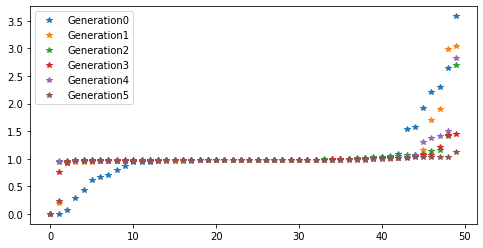

In [15]:
# Code with lower and upper bounds the parameters in Goldbeter's fly clock model.
# I put the published values in comments.

lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;


settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5
settings.eliteCount = 1
settings.selection = 'uniform'

(params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)

plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );

   ## Begin your project here
   
  Complete the project (analyzing the algorithm's performance and the parameters output) here. You can add your new selection operators to the code in cells above. Just concentrate main code for the report here.



Truncation Simulation

Run %d:
 1
Best of generation  1  has cost  0.020465706486490563
Generation  1  has a mean cost of  0.8480169412086515
Best of generation  2  has cost  0.01541244538064496
Generation  2  has a mean cost of  0.4936182882745537
Best of generation  3  has cost  0.014926800672741823
Generation  3  has a mean cost of  0.5817842196300392
Best of generation  4  has cost  0.014773915853185176
Generation  4  has a mean cost of  0.2409854225986414
Best of generation  5  has cost  0.007627118644082495
Generation  5  has a mean cost of  0.10698936616955496
Run %d:
 2
Best of generation  1  has cost  0.11377585818149505
Generation  1  has a mean cost of  0.8937640358938723
Best of generation  2  has cost  0.026225591711024444
Generation  2  has a mean cost of  0.6621122144499472
Best of generation  3  has cost  0.014745027004055927
Generation  3  has a mean cost of  0.2706485868680573
Best of generation  4  has cost  0.011567442312193758
Generation  4  has a mean cost of  0.

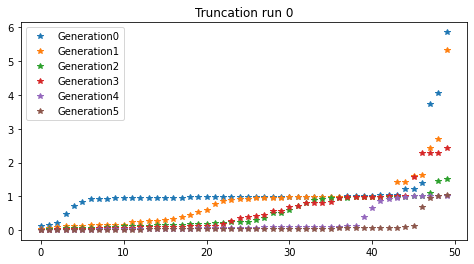

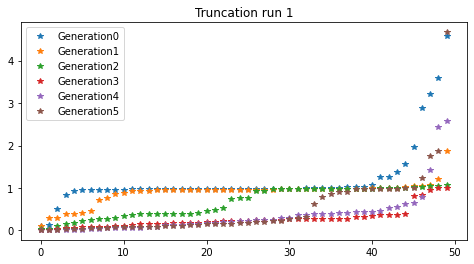

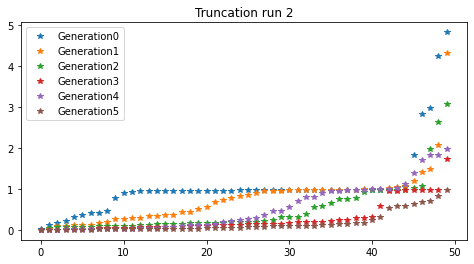

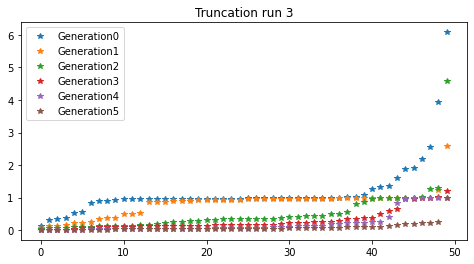

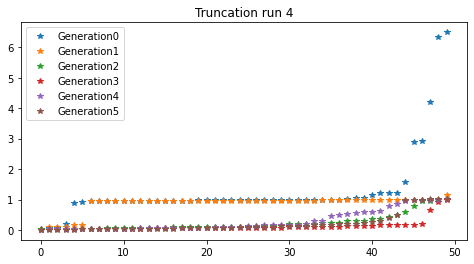

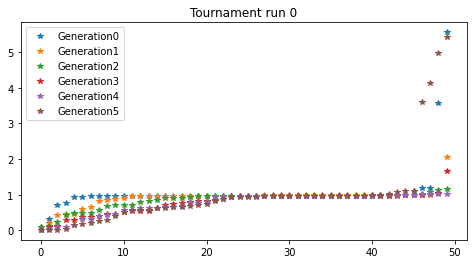

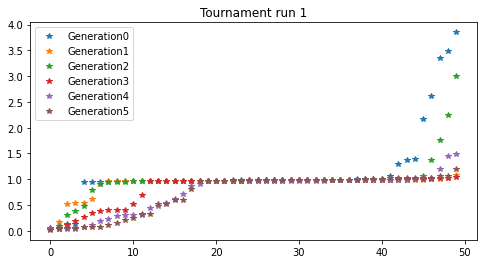

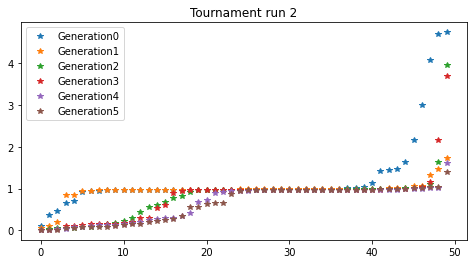

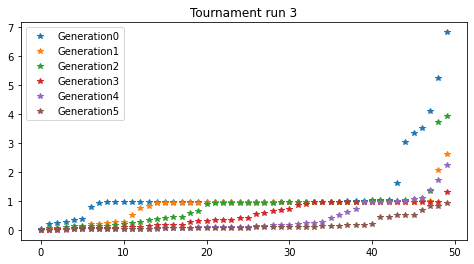

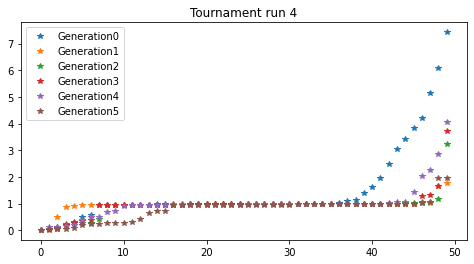

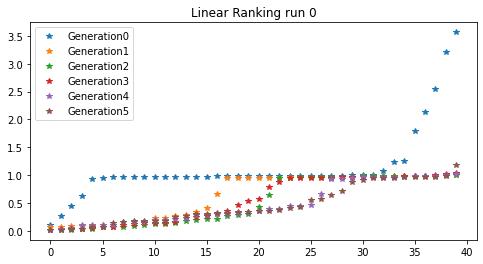

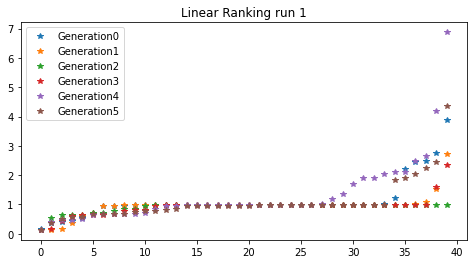

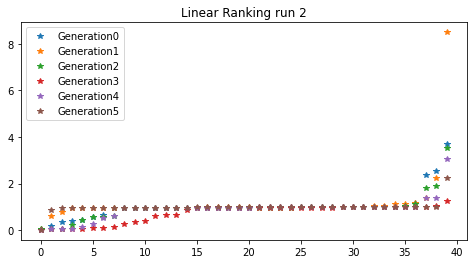

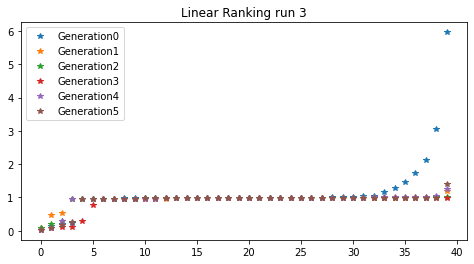

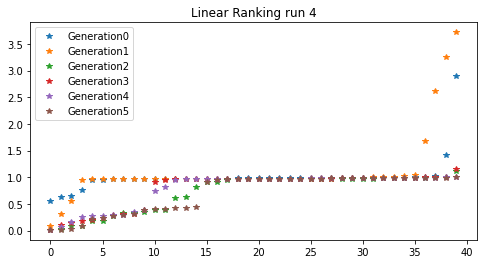

In [26]:
# Start code here and write-up here. :)
# Algorithm Performance
# Run each algorithm on the fly model at least 5 times for each ``flavor'' for at least 5 generations, i.e. analyze performance for
# a GA with truncation selection, an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
# a GA with tournament selection (tournament size = 2), an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
# a GA with linear ranking selection, an elite count of 1, 8 parents, 40 children, and a mutation fraction of 0.05
# Report your results in a concise, but informative manner. You will want to identify trends. To do this, quantify the performance of the algorithm. For example, determine the mean population cost from generation to generation.
vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5
params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;
#save each mean population cost and compare at end
#meanPopulationCost = np.zeros((3,))
print("\nTruncation Simulation\n")
#Truncation Selection, elite count = 1, 10 parents, 50 children, mutation 0.05
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'truncation'
settings.mutation = 0.05
meanList = []
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # print("Cost: ", cost)
    # print("All Costs: ", all_costs)
    # meanPopulationCost[0] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Truncation run " + str(x))
    plt.legend( legs );

print("\nTournament Simulation\n")
#Tournament Selection: elite count = 1, 10 parents, 50 children, mutation 0.05, tournamentSize 2
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'tournament'
settings.mutation = 0.05
settings.tournamentSize = 2
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[1] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Tournament run " + str(x))    
    plt.legend( legs );

print("\nLinear Rank Simulation\n")
#Linear Ranking Selection: elite count = 1, 8 parents, 40 children, mutation 0.05, 
settings = GASettings(numParents=8, numChildren=40)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'linearRanking'
settings.mutation = 0.05

for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[2] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Linear Ranking run " + str(x))
    plt.legend( legs );


#print("Mean Population Cost: ", meanPopulationCost)

## Algorithm performance:

Based on the simulations that we have run, the truncation simulation trend went down relatively fast compared to its counterparts of tournament and linear ranking. The tournament simulation trend has gone down in a similar manner to the truncation and if the tournament size is increased, the trend will decrease even faster per generation. The linear ranking mean/trend for the population cost from generation to generation has stayed relatively around 1. 

## Prediction for Implication for Model

We will change the parameter sets wildly, far from ideal, and expect to see the output of the model, cost, to be very high compared to what it is right now. 

Parameters Changed Substantially

Truncation Simulation

Run %d:
 1
Best of generation  1  has cost  0.011903184481719294
Generation  1  has a mean cost of  0.2396132372951478
Best of generation  2  has cost  0.011903184481719294
Generation  2  has a mean cost of  0.17500446232356745
Best of generation  3  has cost  0.001694915254252055
Generation  3  has a mean cost of  0.2003509844127258
Best of generation  4  has cost  0.001694915254252055
Generation  4  has a mean cost of  0.07484685856478784
Best of generation  5  has cost  0.001694915254252055
Generation  5  has a mean cost of  0.07673253811034177
Run %d:
 2
Best of generation  1  has cost  0.015355099089893945
Generation  1  has a mean cost of  0.3011752646796149
Best of generation  2  has cost  0.012591393304072575
Generation  2  has a mean cost of  0.25596177660050606
Best of generation  3  has cost  0.012591393304072575
Generation  3  has a mean cost of  0.23301555553346887
Best of generation  4  has cost  0.01259139330407257

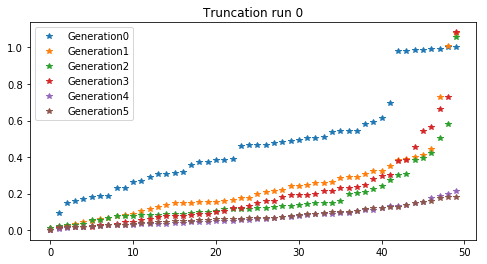

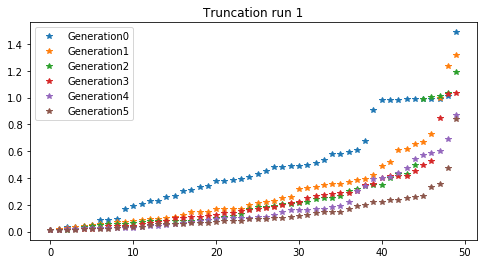

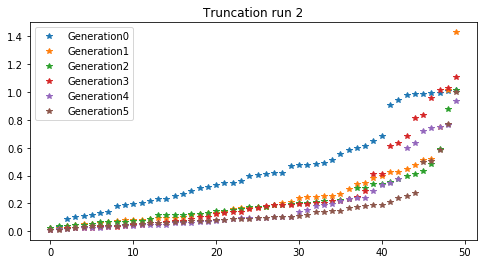

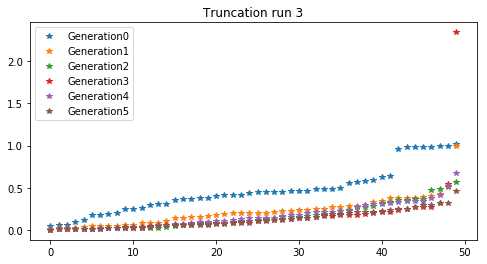

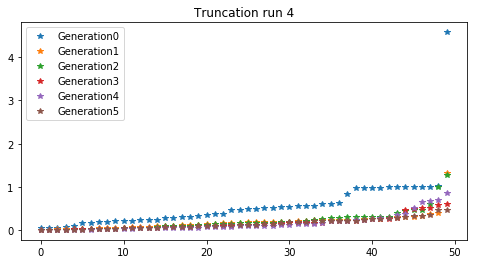

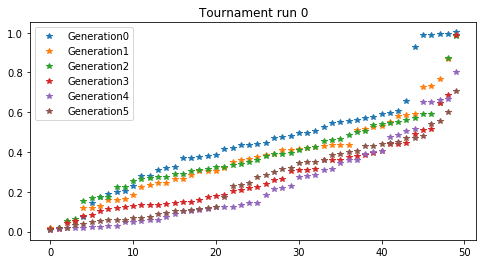

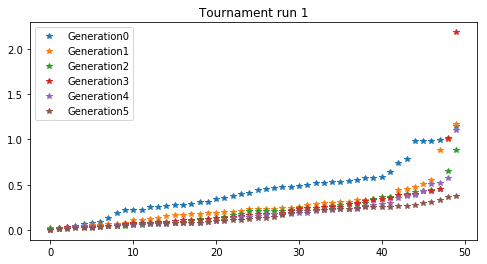

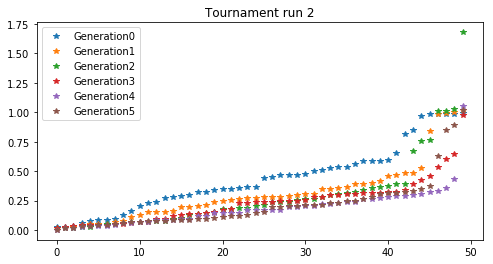

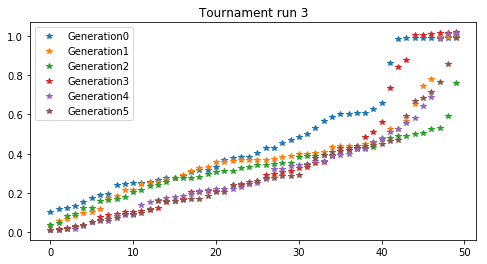

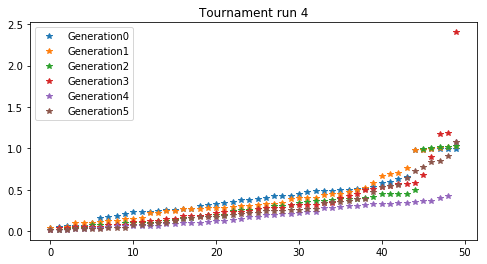

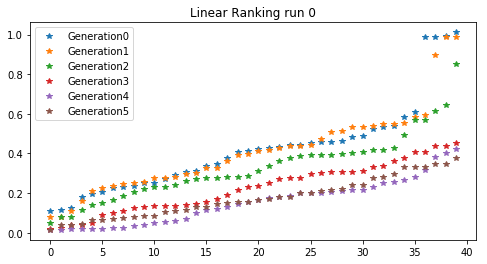

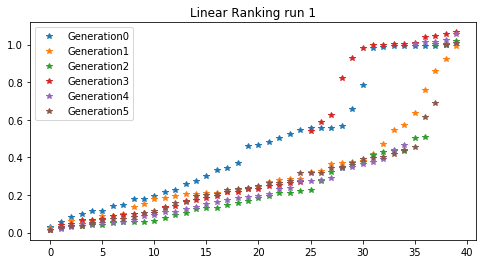

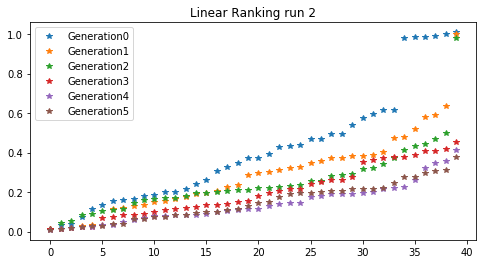

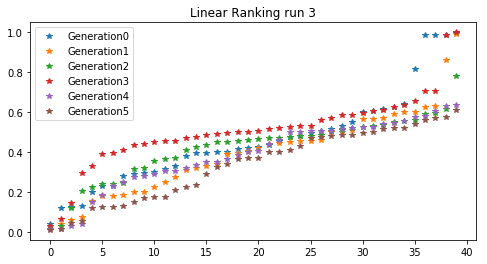

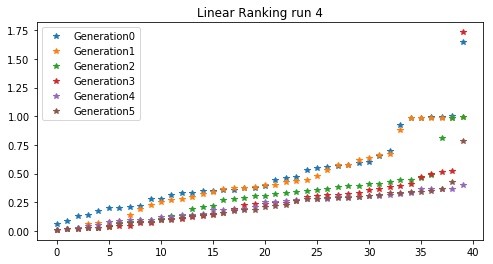

In [6]:
vs = 1.92
vm = 1.92
Km = 1.92
ks = 1.92
vd = 1.92
k1 = 3.6
k2 = 3.6
KI = 1.92
Kd = 1.92
n = 8
K1 = 4
K2 = 5
K3 = 6
K4 = 7
V1 = 6.4
V2 = 3.6
V3 = 10
V4 = 5
print("Parameters Changed Substantially")
params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 1;   ub[0] = 2.5;# vs = 1.92;
lb[1] = 1;   ub[1] = 2.5;# vm = 1.92;
lb[2] = 1;  ub[2] = 2.5;# Km = 1.92;
lb[3] = 1;   ub[3] = 2.5;# ks = 1.92;
lb[4] = 1;   ub[4] = 2.5;# vd = 1.92;
lb[5] = 3;   ub[5] = 4;# k1 = 3.6;
lb[6] = 3;   ub[6] = 4;# k2 = 3.6;
lb[7] = 1;   ub[7] = 3;# KI = 1.92;
lb[8] = 1; ub[8] = 3;# Kd = 1.92;
lb[9] = 8;  ub[9] = 8;# n = 8;
lb[10] = 2;  ub[10] = 6;# K1 = 4;
lb[11] = 4;  ub[11] = 8;# K2 = 5;
lb[12] = 4;  ub[12] = 8;# K3 = 6;
lb[13] = 4;  ub[13] = 8;# K4 = 7;
lb[14] = 4;  ub[14] = 8;# V1 = 6.4;
lb[15] = 0;  ub[15] = 5;# V2 = 3.6;
lb[16] = 5;  ub[16] = 15;# V3 = 10;
lb[17] = 2;  ub[17] = 8;# V4 = 5;
#save each mean population cost and compare at end
#meanPopulationCost = np.zeros((3,))
print("\nTruncation Simulation\n")
#Truncation Selection, elite count = 1, 10 parents, 50 children, mutation 0.05
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'truncation'
settings.mutation = 0.05
meanList = []
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # print("Cost: ", cost)
    # print("All Costs: ", all_costs)
    # meanPopulationCost[0] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Truncation run " + str(x))
    plt.legend( legs );

print("\nTournament Simulation\n")
#Tournament Selection: elite count = 1, 10 parents, 50 children, mutation 0.05, tournamentSize 2
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'tournament'
settings.mutation = 0.05
settings.tournamentSize = 2
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[1] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Tournament run " + str(x))
    plt.legend( legs );

print("\nLinear Rank Simulation\n")
#Linear Ranking Selection: elite count = 1, 8 parents, 40 children, mutation 0.05, 
settings = GASettings(numParents=8, numChildren=40)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'linearRanking'
settings.mutation = 0.05

for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[2] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Linear Ranking run " + str(x))
    plt.legend( legs );



## Implication for the model

Truncation:
0.1 best cost to 0.05, and .2 mean cost to 0.1, so the difference isnt very different. We can see that the best cost in both sets of parameters are kind of close, but possibly because the different parameters are mostly doubled, so we reach another are of the 24 hour period.

Tournament:
0.01 best cost to 0.01, and 0.7 mean cost to 0.3. We also see around the same here in tournament, but with the mean cost, possibly the parameters for lower and upper bound were a little bit different length than the original parameters.

Linear Ranking:
We see a substantial difference where the best cost goes from ~0.02 to ~0.01 and the mean goes from ~0.7 to ~0.2. The substantial difference is in the mean, but not the best cost, meaning that our lower bound and upper bound were probably not as close to the parameters we set as the original. But the best cost is a least a little bit similar because we might have used parameters close to the original parameter values multiplied by 2.

# Extension : Additional analysis: numChildren

Changing children per generation for our best genetic algorithm (because of runtime)

Truncation Simulation

Run %d:
 1
Best of generation  1  has cost  0.03054932222815523
Generation  1  has a mean cost of  0.8213335312512932
Best of generation  2  has cost  0.02692462397575671
Generation  2  has a mean cost of  0.4429381691993555
Best of generation  3  has cost  0.016531229648671743
Generation  3  has a mean cost of  0.3551337947124224
Best of generation  4  has cost  0.015146456880411888
Generation  4  has a mean cost of  0.1745397966034694
Best of generation  5  has cost  0.011350950716143273
Generation  5  has a mean cost of  0.19400213084335607
Run %d:
 2
Best of generation  1  has cost  0.0067796610169779115
Generation  1  has a mean cost of  0.5739033313953896
Best of generation  2  has cost  0.0067796610169779115
Generation  2  has a mean cost of  0.381262187130384
Best of generation  3  has cost  0.0067796610169779115
Generation  3  has a mean cost of  0.25380318027736626
Best of generation  4  has cost  0.0067796610169779115
Generation  4  has a mean cost of 

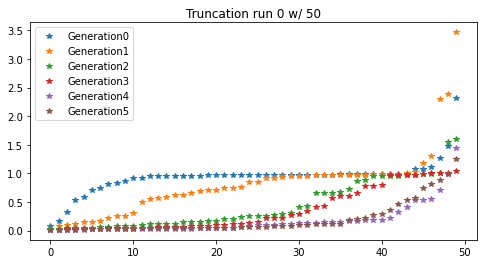

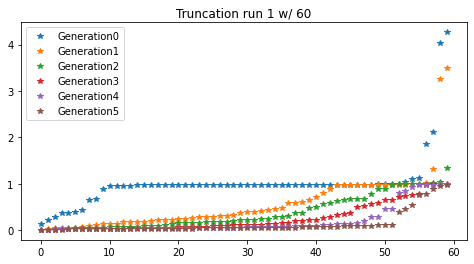

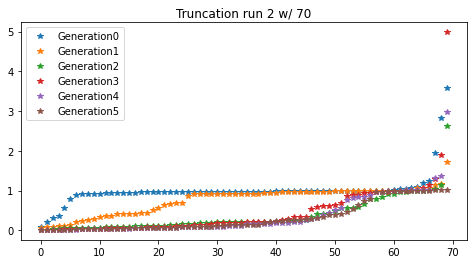

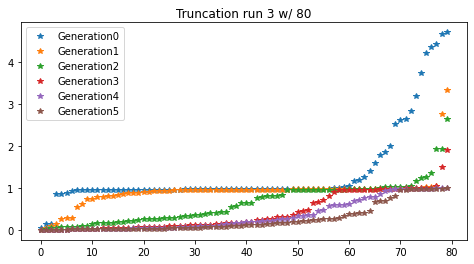

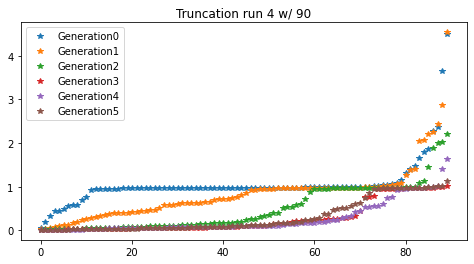

In [40]:
print("Truncation Simulation\n")
vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5
params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;
#Truncation Selection, elite count = 1, 10 parents, 50 children, mutation 0.05
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'truncation'
settings.mutation = 0.05
meanList = []
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # print("Cost: ", cost)
    # print("All Costs: ", all_costs)
    # meanPopulationCost[0] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Truncation run " + str(x) + " w/ " + str(settings.numChildren))
    settings.numChildren += 10
    plt.legend( legs );

## Analysis after simulation (Number of Children)

By having more children, there is more cost because more children make it into the next generation with truncation which does not necessarily mean that they are the best children. 

# Extension : Additional analysis: tournamentSize

Changing the tournament size using the tournament genetic algorithm


Tournament Simulation


Tournament Size is  2 

Run %d:
 1
Best of generation  1  has cost  0.03317669627668383
Generation  1  has a mean cost of  0.9498447568292121
Best of generation  2  has cost  0.030508474576277558
Generation  2  has a mean cost of  0.8414382224338952
Best of generation  3  has cost  0.014312748428576362
Generation  3  has a mean cost of  0.7803458922946472
Best of generation  4  has cost  0.014312748428576362
Generation  4  has a mean cost of  0.7740951562792737
Best of generation  5  has cost  0.014312748428576362
Generation  5  has a mean cost of  0.8469957049483411
Run %d:
 2
Best of generation  1  has cost  0.07589778645089529
Generation  1  has a mean cost of  0.8054606758430226
Best of generation  2  has cost  0.029075951545738866
Generation  2  has a mean cost of  0.7085256469786668
Best of generation  3  has cost  0.022052303096350652
Generation  3  has a mean cost of  0.5674648467701391
Best of generation  4  has cost  0.022052303096350652
Generation  4

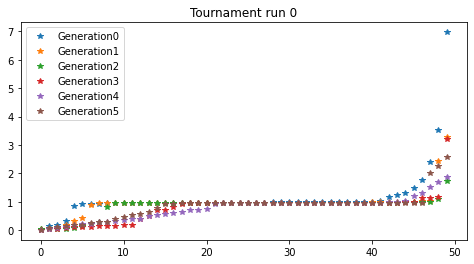

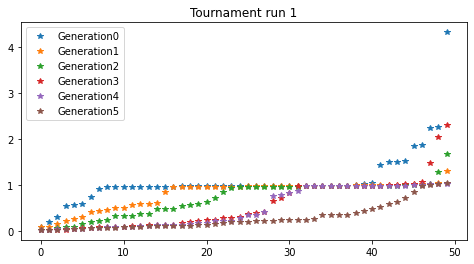

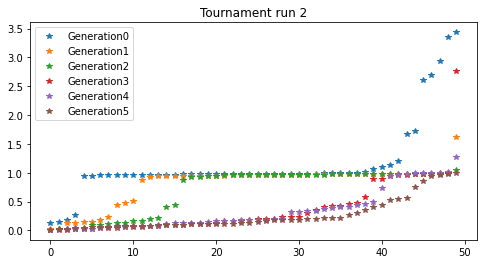

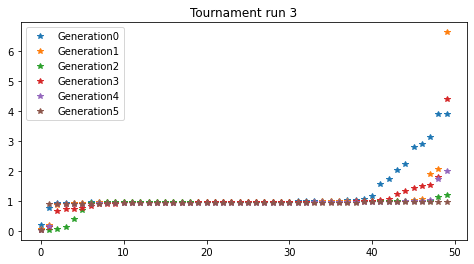

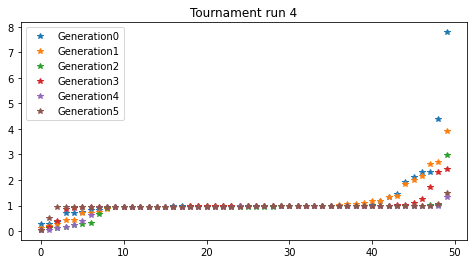

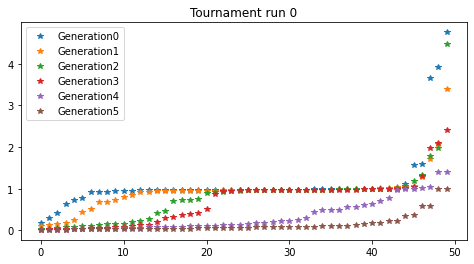

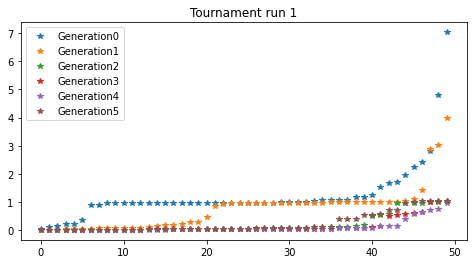

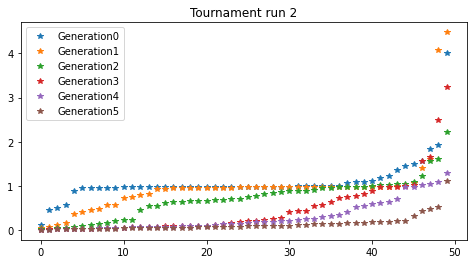

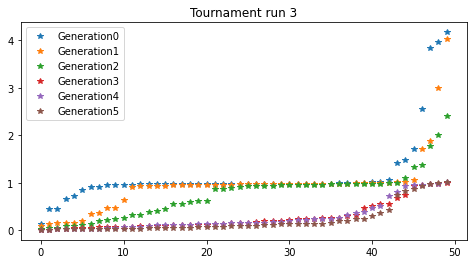

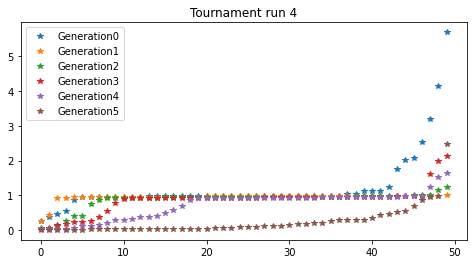

In [41]:
print("\nTournament Simulation\n")
vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5
params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;
#Tournament Selection: elite count = 1, 10 parents, 50 children, mutation 0.05, tournamentSize 2
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'tournament'
settings.mutation = 0.05
settings.tournamentSize = 2
print("\nTournament Size is ",settings.tournamentSize,"\n")
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[1] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Tournament run " + str(x))    
    plt.legend( legs );


settings.tournamentSize = 5
print("\nTournament Size is ",settings.tournamentSize,"\n")
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[1] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Tournament run " + str(x))    
    plt.legend( legs );



## Analysis after simulation (Tournament Size)

With the increase of the tournamentSize, we see a general trend for the cost to improve rapidly as more generations are made. This is because as you increase the tournament size, there are more competitors in the tournament and more and more individuals are being eliminated.

# Extension : Additional analysis: linearRankingRatio

Changing the linear ranking ratio to something higher than 4 and seeing what differences there are


Linear Rank Simulation


Linear Ranking Ratio is  4 

Run %d:
 1
Best of generation  1  has cost  0.014098674418552408
Generation  1  has a mean cost of  1.0574880657077101
Best of generation  2  has cost  0.014098674418552408
Generation  2  has a mean cost of  0.9355081115268854
Best of generation  3  has cost  0.014098674418552408
Generation  3  has a mean cost of  1.1550780494042823
Best of generation  4  has cost  0.014098674418552408
Generation  4  has a mean cost of  0.8365506327803693
Best of generation  5  has cost  0.014098674418552408
Generation  5  has a mean cost of  0.885575563593662
Run %d:
 2
Best of generation  1  has cost  0.091676149046954
Generation  1  has a mean cost of  0.8658426234402867
Best of generation  2  has cost  0.06153211457434548
Generation  2  has a mean cost of  0.7827990856595927
Best of generation  3  has cost  0.021497518558166503
Generation  3  has a mean cost of  0.9260462388510875
Best of generation  4  has cost  0.021497518558166503
Generation

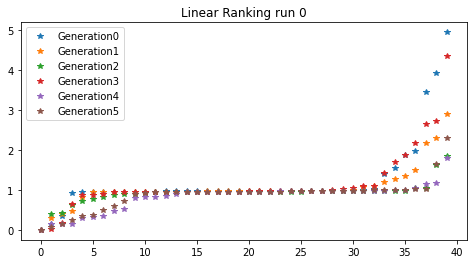

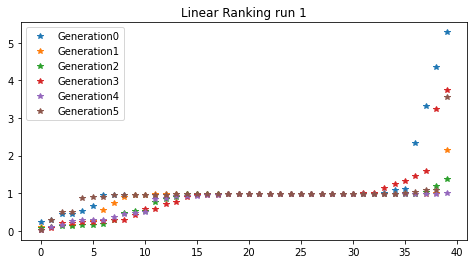

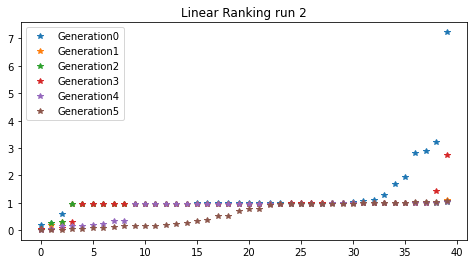

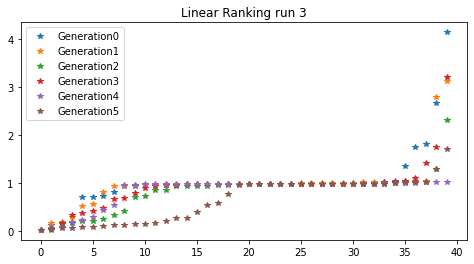

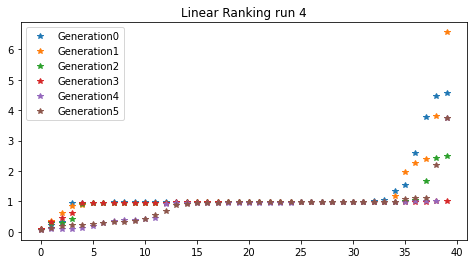

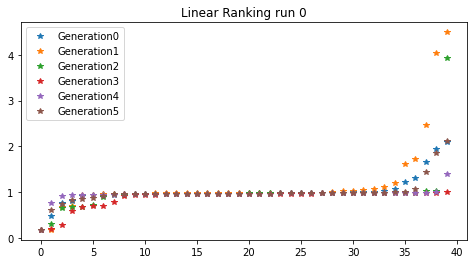

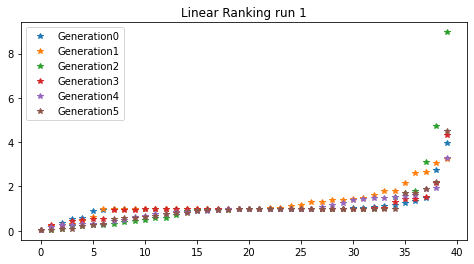

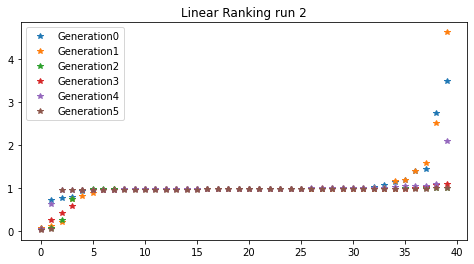

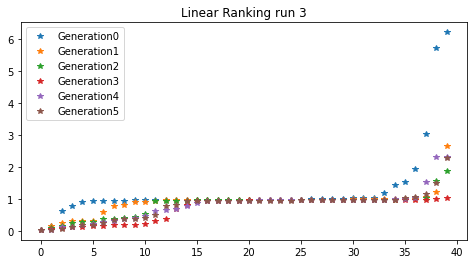

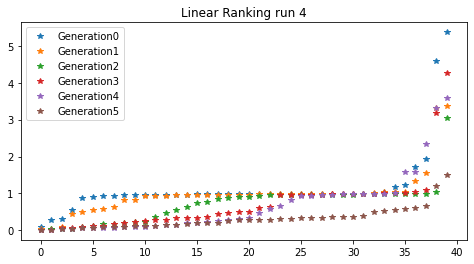

In [42]:
print("\nLinear Rank Simulation\n")
vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5
params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;
#Linear Ranking Selection: elite count = 1, 8 parents, 40 children, mutation 0.05, 
settings = GASettings(numParents=8, numChildren=40)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'linearRanking'
settings.mutation = 0.05

print("\nLinear Ranking Ratio is ",settings.linearRankingRatio,"\n")
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[2] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Linear Ranking run " + str(x))
    plt.legend( legs );



settings.linearRankingRatio = 8
print("\nLinear Ranking Ratio is ",settings.linearRankingRatio,"\n")
for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[2] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Linear Ranking run " + str(x))
    plt.legend( legs );

## Analysis of Simulation (Linear Ranking Ratio)

As the linear ranking ratio increased, we noticed the trend that the cost has generally decreased. This is most likely becuase with the increase of ratio there are more and more competitors eliminated through the generation. As the graph shows, the cost decreases more quickly in each generation with the high ratio as they get to the optimal cost for 5 generations of children.

# Extension : Implementation of Proportional Selection

Based on the roulette-wheel selection where the implementation is:

1. The fitness function is evaluated for each individual, providing fitness values, which are then normalized. Normalization means dividing the fitness value of each individual by the sum of all fitness values, so that the sum of all resulting fitness values equals 1.
2, Accumulated normalized fitness values are computed: the accumulated fitness value of an individual is the sum of its own fitness value plus the fitness values of all the previous individuals; the accumulated fitness of the last individual should be 1, otherwise something went wrong in the normalization step.
3. A random number R between 0 and 1 is chosen.
4. The selected individual is the first one whose accumulated normalized value is greater than or equal to R.

As of right now we do not know how the genetic algorithm will function.


Proportional Selection Simulation

Run %d:
 1
Best of generation  1  has cost  0.03732546616015587
Generation  1  has a mean cost of  0.815340674978592
Best of generation  2  has cost  0.020081165710715308
Generation  2  has a mean cost of  0.8530146344683692
Best of generation  3  has cost  0.020081165710715308
Generation  3  has a mean cost of  0.8810999711523089
Best of generation  4  has cost  0.020081165710715308
Generation  4  has a mean cost of  0.9564975159651486
Best of generation  5  has cost  0.020081165710715308
Generation  5  has a mean cost of  0.9350617440954367
Run %d:
 2
Best of generation  1  has cost  0.05411959044987996
Generation  1  has a mean cost of  0.9237911544456388
Best of generation  2  has cost  0.05411959044987996
Generation  2  has a mean cost of  1.025785649326766
Best of generation  3  has cost  0.05411959044987996
Generation  3  has a mean cost of  1.0061670481110674
Best of generation  4  has cost  0.05411959044987996
Generation  4  has a mean cost 

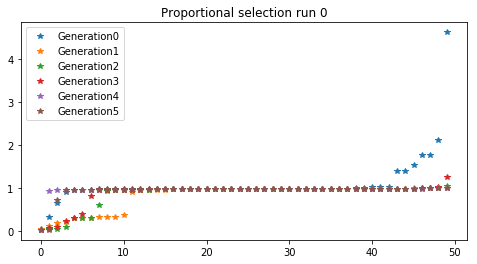

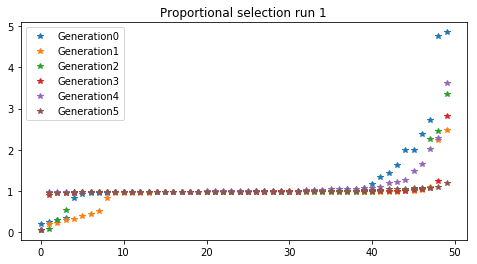

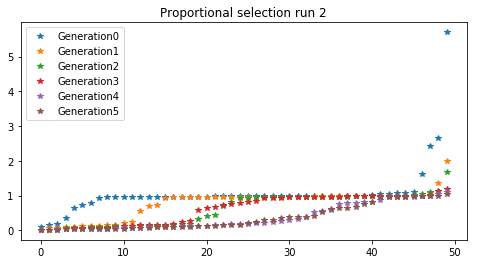

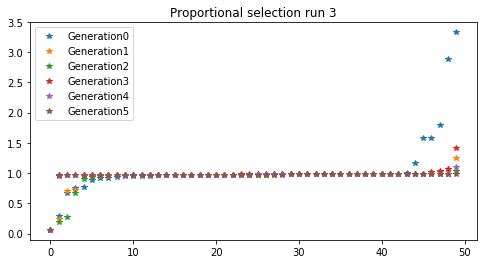

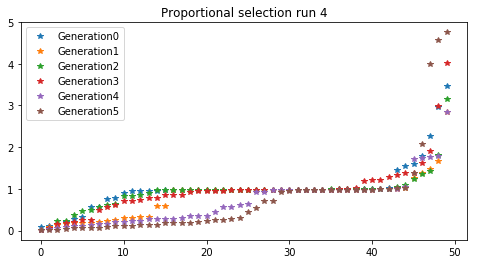

In [6]:
print("\nProportional Selection Simulation\n")
vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5
params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;
#Linear Ranking Selection: elite count = 1, 10 parents, 50 children, mutation 0.05, 
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'proportional'
settings.mutation = 0.05

for x in range(5):
    print('Run %d:\n', x + 1)
    (params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    # meanPopulationCost[2] = np.mean(all_costs)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Proportional selection run " + str(x))
    plt.legend( legs );

## Analysis of Simulation (Proportional Selection)
I find that the proportional selection method of the genetic algorithm finds a best cost, and really favors one individual, then just keeps picking that individual. It does something similar to the linear ranking system, where we look at ranges, but the visualization of the proportional selection is the roulette wheel, compared to a sliced bar and is extremely biased. The means do not go down because the pool of people chosen from remains large.

We get down to a low cost very fast without too many generations.

# Extension : Goodwin Parameters

In [1]:
#goodwin oscillator
def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt

def goodwin_circadian_error( params, debug=False ):
    mf = lambda t,y : goodwin_oscillator(t,y, params)
    sol1 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,500), y0=(.1,.1,.1) )
    sol2 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,100), y0=sol1.y[:,-1], 
                                    t_eval=np.arange(0,100,.01) )
    # Compute the period of the first state. It is a scalar.
    (period,sdper) = get_period( sol2.t, sol2.y[0,:] )
    # compute the peak-to-trough amp for each state
    # by computing the min and max over time and subtracting.
    # amps will be an ndarray of length 3.
    amps = sol2.y.max(axis=1)-sol2.y.min(axis=1)
    # an amplitude larger than 0.1 is going to have low cost
    # scale the amplitudes and then compute the exponential for
    # each amp. Since log(0.001)<0, the curve will be decreasing
    # as the amplitude is increasing. 
    # amp_errvals will be an ndarray of length 3.
    rate = np.log(0.001)/0.1;
    amp_errvals = np.exp(np.multiply(rate,amps));
    # The amplitude cost is the sum of the 3 amplitude error values.
    acost = amp_errvals.sum()
    # amplitude should not be shrinking or growing
    # compute the 3 amplitudes for the first half of the simulation
    # and then for the second
    half = sol2.y.shape[1]//2
    amps1 = sol2.y[:,:half].max(axis=1)-sol2.y[:,:half].min(axis=1)
    amps2 = sol2.y[:,half:].max(axis=1)-sol2.y[:,half:].min(axis=1)
    if debug:
        print( amps1 )
        print(amps2)
    # sum the amplitudes and take their difference. Then multiply
    # the difference by 100 (to amplify it) and square the result.
    bcost = (100*(amps1.sum()-amps2.sum()))**2
    if debug:
        print((period-24)**2, acost, bcost, amps1.sum(), amps2.sum() )

    # The total cost is the squared difference between the period and 24 hours 
    # plue the two amplitude costs. We weight the acost with 5 because it values
    # tend to be small.
    return (period-24)**2 + 5*acost + bcost

In [2]:
#here we can use a working set of parameters
# alpha_1 = 1
# K = 0.61
# n = 11
# gamma_1 = 0.15
# alpha_2 = 1
# gamma_2 = 0.15
# alpha_3 = 1
# gamma_3 = 0.25

#lb = np.array([0.1,0.1,7,0.01,0.5,0.01,0.5,0.01])
lb = np.array([0.001,0.001,4,0.001,0.05,0.001,0.05,0.001])
ub = np.array( [2,2,15,1,2,1,2,1])

settings = GASettings(numParents=50, numChildren=250)
settings.numGenerations = 5
settings.eliteCount = 1
settings.selection = 'linearRanking'
settings.linearRankingRatio = 8

(params, cost, all_params, all_costs) = GA(goodwin_circadian_error, lb, ub, settings)
#plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.title("Linear Ranking selection run on goodwin oscillator #" + str(x))
plt.legend( legs );

NameError: name 'np' is not defined

## Analysis of Goodwin Parameters

We would have liked to be able to express a concise analysis of the goodwin parameter but due to the long runtime and the project deadline we were unable to complete the analysis by the deadline but would have liked to display the code that we developed to test some of the goodwin parameters.


<hr style="border:2px solid gray"> </hr>

Acknowledgements

https://en.wikipedia.org/wiki/Selection_(genetic_algorithm) - to develop code for the proportional selection


*Replace this text with links to external resources and thanks to people you worked with.*